In [2]:
import os,json,random
from collections import defaultdict
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
from cycler import cycler

In [3]:
def createConceptDict(allConcepts,json_data):
    treshold = 0.8
    # Create a dict of lists. For each concept we have a dict of the size duration of the video
    ## 0 where the concept is not present and 1 where is present
    conceptDict=defaultdict(list,{k:[] for k in allConcepts})

    for key in conceptDict.keys():
        for frame in json_data:
            found = False
            for concept in frame['data']['concepts']:
                if key == concept['name'] and concept['value'] > treshold:
                    conceptDict[key].append(1)
                    found = True
                    break
            if not found:
                conceptDict[key].append(0)
    return conceptDict

In [4]:
# Create a set with every concept name
def createAllConcepts(json_data):
    allConcepts = set()
    for frame in json_data:
        for concept in frame['data']['concepts']:
            if concept['name'] not in allConcepts:
                allConcepts.add(concept['name']) 
            #print('%s %f' % (concept['name'], concept['value']))
    return allConcepts

In [5]:
def findOcorrences(myList):
    i = 0
    timeTuplesList = []
    while i < len(myList):
        n = myList[i]
        if n == 1:
            startTime = i
            duration = 1
            while i < len(myList) - 1 and myList[i] == myList[i + 1]:
                duration = duration + 1
                i = i + 1
            timeTuplesList.append((startTime, duration))
        i = i + 1
    return timeTuplesList

In [6]:
def mergeConcepts(*lists):
    # create list of zeros with the size of the first list argument
    outList = [0] * len(lists[0])
    for elem in lists:
        outList = [a or b for a, b in zip(outList, elem)]
    return outList

In [7]:
def hashColorFromName(name):
    numb = 0
    for ch in name:
        numb += ord(ch)
    return numb

In [183]:
def plotConcepts(filename,detectedConcepts,predictions):
    
    fig, gnt = plt.subplots(figsize=(15, 2)) 

    # Setting Y-axis limits 
    gnt.set_ylim(0, len(detectedConcepts)*10) 

    # Setting X-axis limits 
    videoSize = len(conceptDict[random.choice(list(conceptDict))])
    gnt.set_xlim(0, videoSize)
    tickList = list(range(0, videoSize, 2))
    tickList.append(videoSize)
   
    plt.xticks(tickList)

    #gnt.xaxis.set_major_locator(ticker.MultipleLocator(5))


    # Setting labels for x-axis and y-axis 
    fig.suptitle(filename, y=1.2,fontsize=15)
    gnt.set_xlabel('Video Seconds') 
    gnt.set_ylabel('Tags') 

    # Setting ticks on y-axis 
    gnt.set_yticks([x*10 for x in range(0,len(detectedConcepts))])
    # Labelling tickes of y-axis 
    gnt.set_yticklabels(detectedConcepts) 
    # aligning ticks
    for tick in gnt.yaxis.get_majorticklabels():
        tick.set_verticalalignment('bottom')


    # Setting graph color attribute 
    gnt.grid(True) 
    gnt.set_axisbelow(True)
    cmap = plt.cm.get_cmap('hsv', len(detectedConcepts)+1)

    inc = 0
    i = 0
    for concept in detectedConcepts:
        gnt.broken_barh(predictions[concept], 
                        (inc, 10),facecolors =(cmap(i)),
                        edgecolors=('black'),
                        linewidth=1,
                        alpha=1)
        inc+=10
        i+=1
    if filename == "babylonad 1 d": plt.savefig('babylonad 1 d.pdf',bbox_inches='tight')
    plt.show()

In [184]:
predictions['Manual']

[(5, 0.2999999999999998),
 (14.3, 0.3999999999999986),
 (18.7, 0.3000000000000007),
 (22.6, 0.1999999999999993)]

Video : 2012 official trailer 4 hd


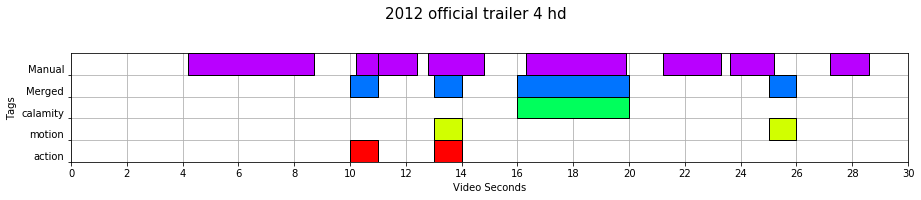

acertos:
	 (10.199988888888889, 0.800011111111111) tem interseção com (10, 1)
	 (11, 1.4000000000000004) tem interseção com (10, 1)
	 (12.8, 2.0) tem interseção com (13, 1)
	 (16.3, 3.5999888888888876) tem interseção com (16, 4)
	 (23.6, 1.5999999999999979) tem interseção com (25, 1)
5 acertos para um total de 8 efeitos
acerto de 62%
Video : a chinese ghost story1 xvid


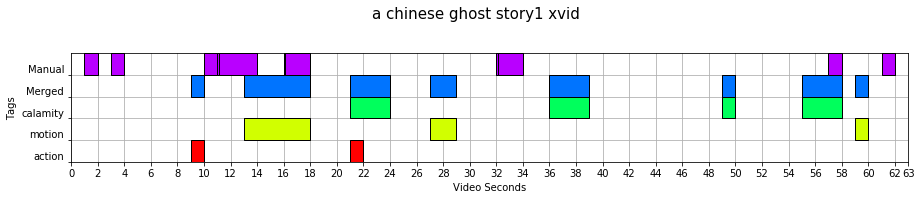

acertos:
	 (10, 1) tem interseção com (9, 1)
	 (11.1, 2.9000000000000004) tem interseção com (13, 5)
	 (16, 0.10000000000000142) tem interseção com (13, 5)
	 (16.1, 1.8999999999999986) tem interseção com (13, 5)
	 (57, 1) tem interseção com (55, 3)
5 acertos para um total de 11 efeitos
acerto de 45%
Video : afterlife


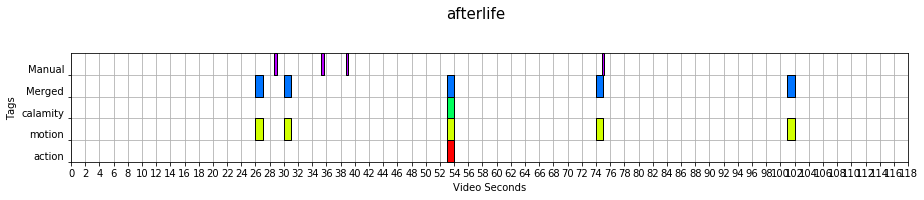

acertos:
	 (74.8, 0.2999888888888904) tem interseção com (74, 1)
1 acertos para um total de 4 efeitos
acerto de 25%
Video : alien 600 128kbmp3


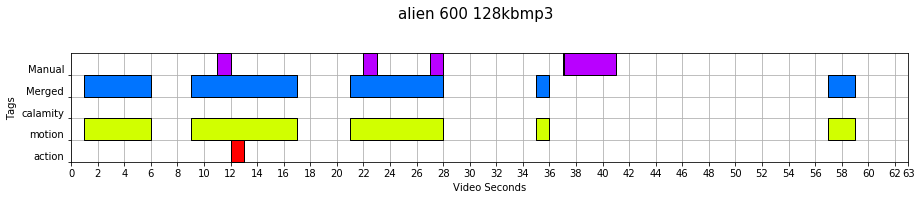

acertos:
	 (11, 1) tem interseção com (9, 8)
	 (22, 1) tem interseção com (21, 7)
	 (27, 1) tem interseção com (21, 7)
3 acertos para um total de 5 efeitos
acerto de 60%
Video : alien-resurrection-teaser-640


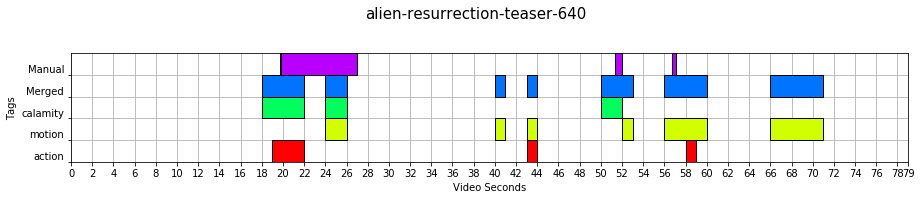

acertos:
	 (19.7, 0.10000000000000142) tem interseção com (18, 4)
	 (19.8, 7.199999999999999) tem interseção com (18, 4)
	 (51.3, 0.7000000000000028) tem interseção com (50, 3)
	 (56.7, 0.3999999999999986) tem interseção com (56, 4)
4 acertos para um total de 4 efeitos
acerto de 100%
Video : babylon ad trailer hd


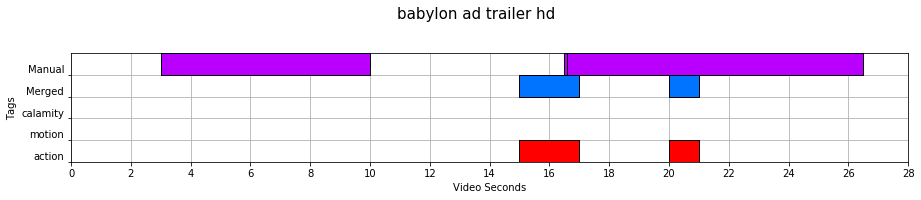

acertos:
	 (16.5, 0.10000000000000142) tem interseção com (15, 2)
	 (16.6, 9.899999999999999) tem interseção com (15, 2)
2 acertos para um total de 3 efeitos
acerto de 66%
Video : babylonad 1 b


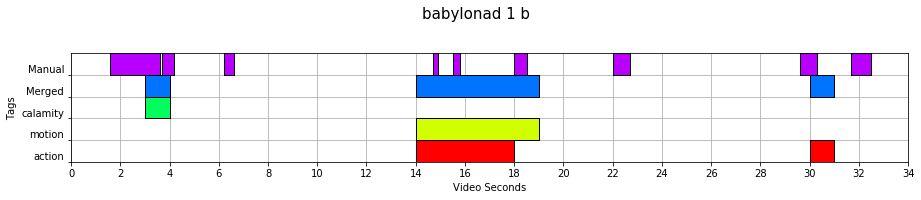

acertos:
	 (1.6, 2.0) tem interseção com (3, 1)
	 (3.7, 0.5) tem interseção com (3, 1)
	 (14.7, 0.20000000000000107) tem interseção com (14, 5)
	 (15.5, 0.3000000000000007) tem interseção com (14, 5)
	 (18, 0.5) tem interseção com (14, 5)
	 (29.6, 0.6999999999999993) tem interseção com (30, 1)
6 acertos para um total de 9 efeitos
acerto de 66%
Video : babylonad 1 c


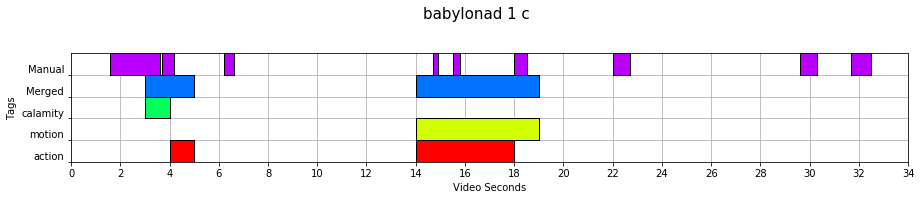

acertos:
	 (1.6, 2.0) tem interseção com (3, 2)
	 (3.7, 0.5) tem interseção com (3, 2)
	 (14.7, 0.20000000000000107) tem interseção com (14, 5)
	 (15.5, 0.3000000000000007) tem interseção com (14, 5)
	 (18, 0.5) tem interseção com (14, 5)
5 acertos para um total de 9 efeitos
acerto de 55%
Video : babylonad 1 d


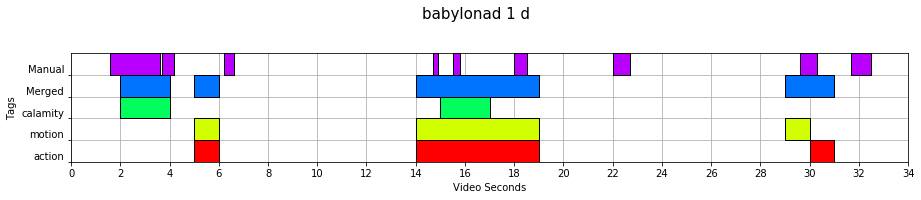

acertos:
	 (1.6, 2.0) tem interseção com (2, 2)
	 (3.7, 0.5) tem interseção com (2, 2)
	 (14.7, 0.20000000000000107) tem interseção com (14, 5)
	 (15.5, 0.3000000000000007) tem interseção com (14, 5)
	 (18, 0.5) tem interseção com (14, 5)
	 (29.6, 0.6999999999999993) tem interseção com (29, 2)
6 acertos para um total de 9 efeitos
acerto de 66%
Video : babylonad 1


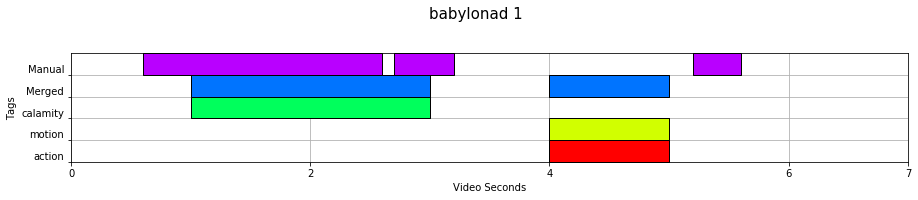

acertos:
	 (0.6, 2.0) tem interseção com (1, 2)
	 (2.7, 0.5) tem interseção com (1, 2)
2 acertos para um total de 3 efeitos
acerto de 66%
Video : babylonad 2


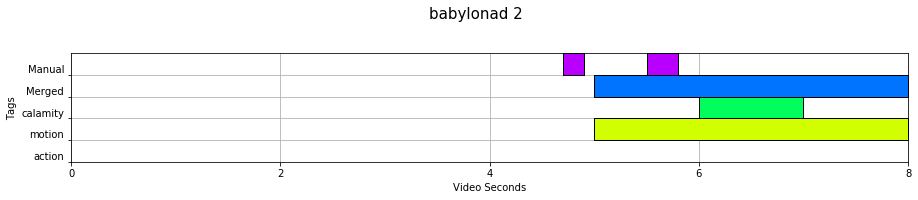

acertos:
	 (5.5, 0.2999999999999998) tem interseção com (5, 3)
1 acertos para um total de 2 efeitos
acerto de 50%
Video : babylonad 3


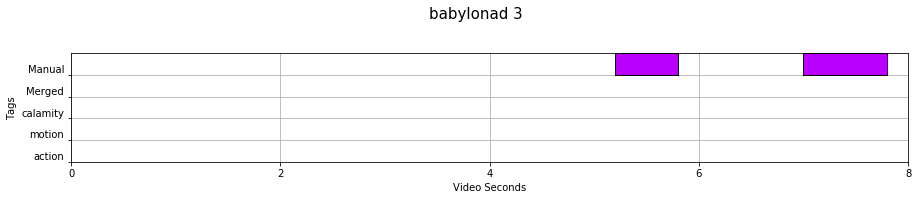

acertos:
0 acertos para um total de 2 efeitos
acerto de 0%
Video : babylonad short


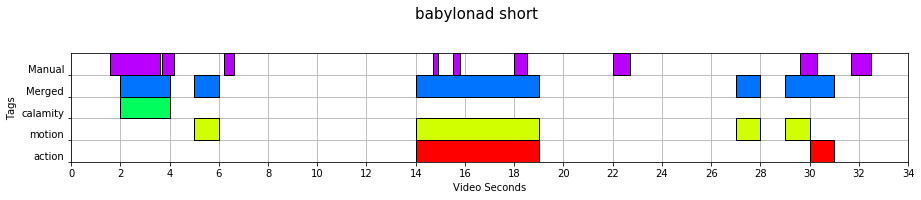

acertos:
	 (1.6, 2.0) tem interseção com (2, 2)
	 (3.7, 0.5) tem interseção com (2, 2)
	 (14.7, 0.20000000000000107) tem interseção com (14, 5)
	 (15.5, 0.3000000000000007) tem interseção com (14, 5)
	 (18, 0.5) tem interseção com (14, 5)
	 (29.6, 0.6999999999999993) tem interseção com (29, 2)
6 acertos para um total de 9 efeitos
acerto de 66%
Video : babylonad shortogg


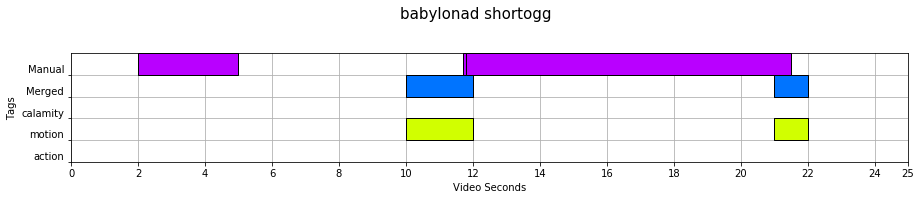

acertos:
	 (11.7, 0.10000000000000142) tem interseção com (10, 2)
	 (11.8, 9.7) tem interseção com (10, 2)
2 acertos para um total de 3 efeitos
acerto de 66%
Video : babylonad trlr 01 1080p dl


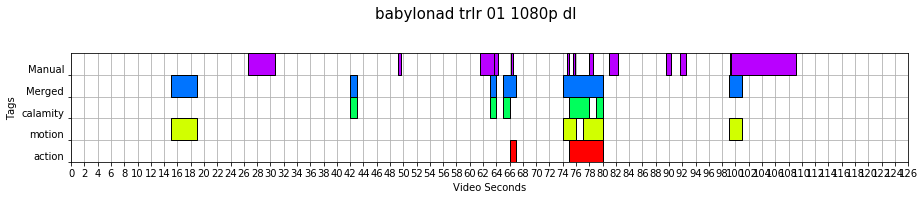

acertos:
	 (61.6, 2.0) tem interseção com (63, 1)
	 (63.7, 0.5) tem interseção com (63, 1)
	 (66.2, 0.39998888888888473) tem interseção com (65, 2)
	 (74.7, 0.20000000000000284) tem interseção com (74, 6)
	 (75.5, 0.29999999999999716) tem interseção com (74, 6)
	 (78, 0.5) tem interseção com (74, 6)
	 (99.2, 0.09999999999999432) tem interseção com (99, 2)
	 (99.3, 9.900000000000006) tem interseção com (99, 2)
8 acertos para um total de 13 efeitos
acerto de 61%
Video : babylonad


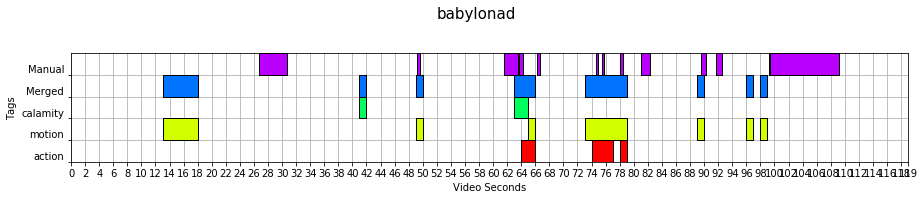

acertos:
	 (49.2, 0.3999999999999986) tem interseção com (49, 1)
	 (61.6, 2.0) tem interseção com (63, 3)
	 (63.7, 0.5) tem interseção com (63, 3)
	 (74.7, 0.20000000000000284) tem interseção com (73, 6)
	 (75.5, 0.29999999999999716) tem interseção com (73, 6)
	 (78, 0.5) tem interseção com (73, 6)
	 (89.59998888888889, 0.7000111111111096) tem interseção com (89, 1)
7 acertos para um total de 13 efeitos
acerto de 53%
Video : centurio


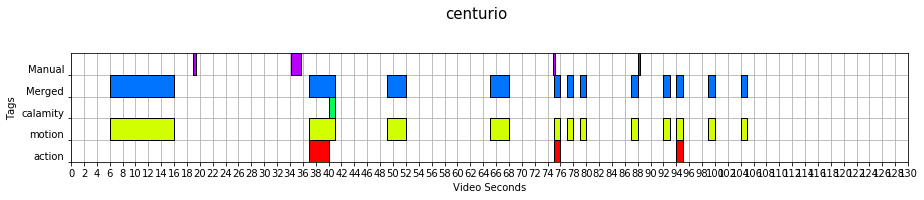

acertos:
	 (74.9, 0.1999888888888819) tem interseção com (75, 1)
1 acertos para um total de 4 efeitos
acerto de 25%
Video : csi


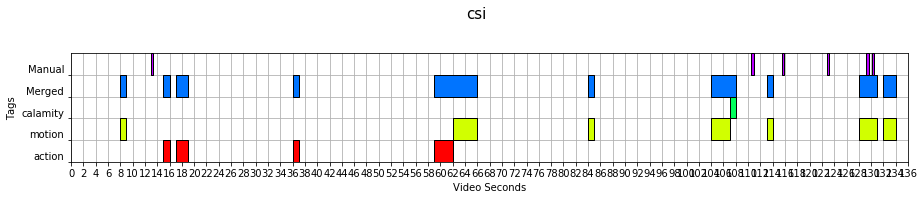

acertos:
	 (129.1999888888889, 0.4000111111110982) tem interseção com (128, 3)
	 (130.1, 0.30000000000001137) tem interseção com (128, 3)
2 acertos para um total de 6 efeitos
acerto de 33%
Video : fastandfurious 1


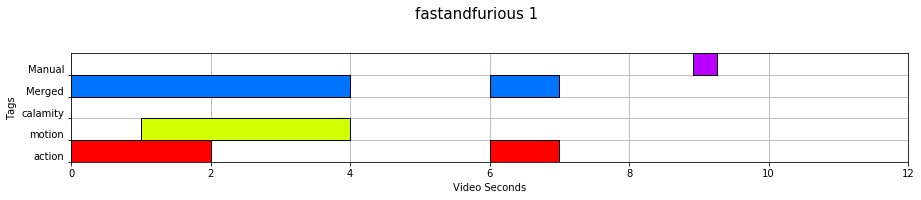

acertos:
0 acertos para um total de 1 efeitos
acerto de 0%
Video : fastandfurious 2


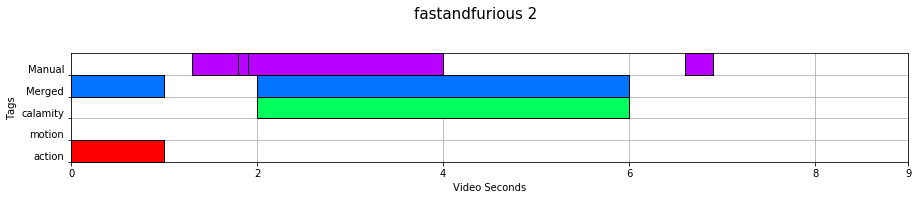

acertos:
	 (1.9, 2.1) tem interseção com (2, 4)
1 acertos para um total de 4 efeitos
acerto de 25%
Video : fastandfurious 3


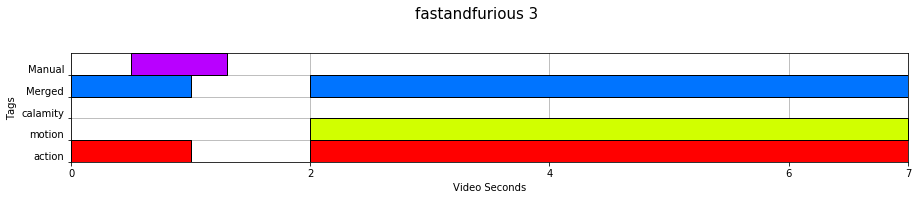

acertos:
	 (0.5, 0.8) tem interseção com (0, 1)
1 acertos para um total de 1 efeitos
acerto de 100%
Video : fastandfurious


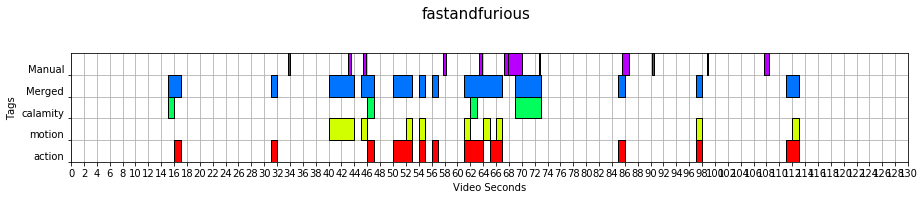

acertos:
	 (43, 0.3999999999999986) tem interseção com (40, 4)
	 (45.4, 0.3999999999999986) tem interseção com (45, 2)
	 (63.4, 0.3999999999999986) tem interseção com (61, 6)
	 (67.9, 2.0999999999999943) tem interseção com (69, 4)
	 (72.6, 0.30000000000001137) tem interseção com (69, 4)
	 (85.5, 1.2000000000000028) tem interseção com (85, 1)
6 acertos para um total de 13 efeitos
acerto de 46%
Video : fringe


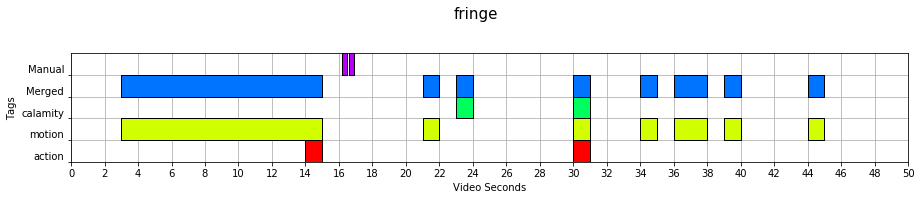

acertos:
0 acertos para um total de 2 efeitos
acerto de 0%
Video : indiana jones 4-tlr2 h720p


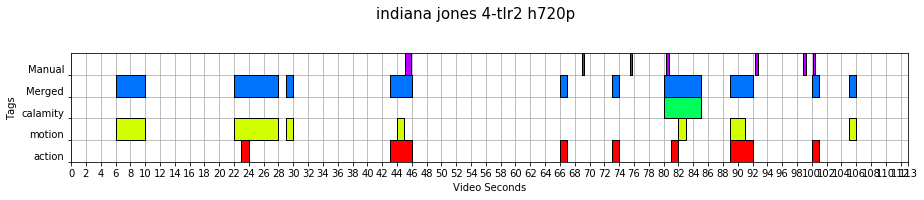

acertos:
	 (45.1, 0.7999999999999972) tem interseção com (43, 3)
	 (80.3, 0.4000000000000057) tem interseção com (80, 5)
	 (100.2, 0.29999999999999716) tem interseção com (100, 1)
3 acertos para um total de 7 efeitos
acerto de 42%
Video : indy4 1


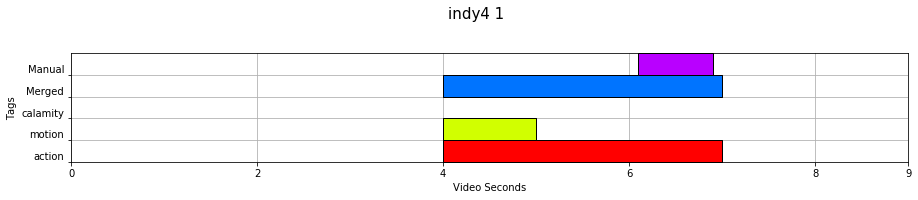

acertos:
	 (6.1, 0.8000000000000007) tem interseção com (4, 3)
1 acertos para um total de 1 efeitos
acerto de 100%
Video : indy4 2


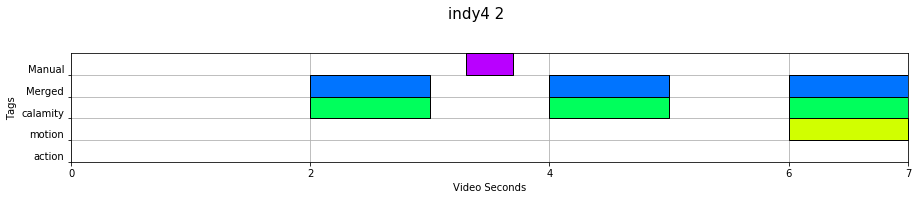

acertos:
0 acertos para um total de 1 efeitos
acerto de 0%
Video : indy4 3


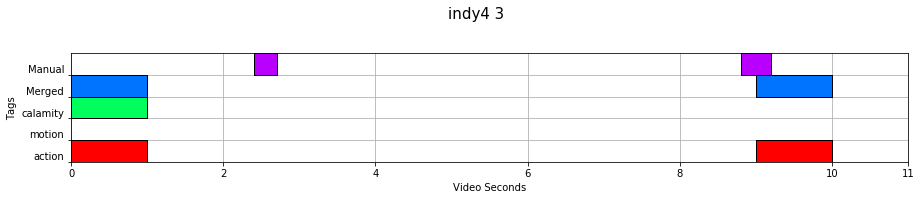

acertos:
	 (8.8, 0.3999999999999986) tem interseção com (9, 1)
1 acertos para um total de 2 efeitos
acerto de 50%
Video : iron man 2 trailer official


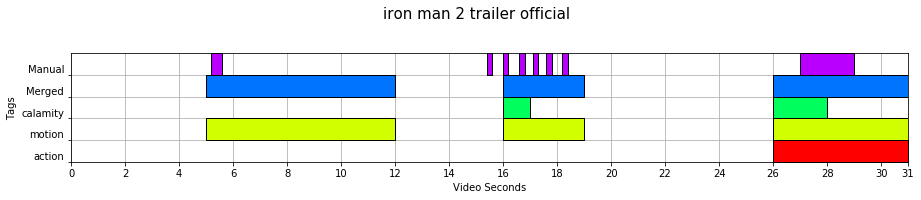

acertos:
	 (5.2, 0.399977777777778) tem interseção com (5, 7)
	 (16, 0.1999999999999993) tem interseção com (16, 3)
	 (16.6, 0.1999999999999993) tem interseção com (16, 3)
	 (17.1, 0.1999999999999993) tem interseção com (16, 3)
	 (17.6, 0.1999999999999993) tem interseção com (16, 3)
	 (18.2, 0.199988888888889) tem interseção com (16, 3)
	 (27, 2) tem interseção com (26, 5)
7 acertos para um total de 8 efeitos
acerto de 87%
Video : kick ass debut movie teaser trailer hd


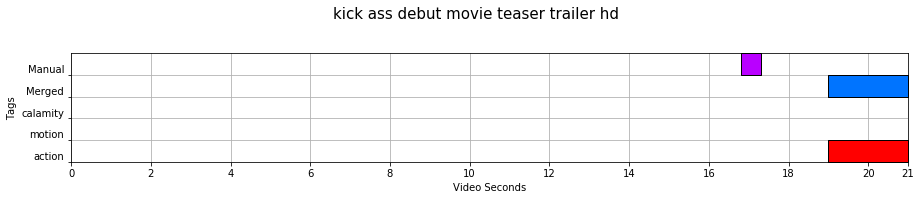

acertos:
0 acertos para um total de 1 efeitos
acerto de 0%
Video : passwordswordfish 1


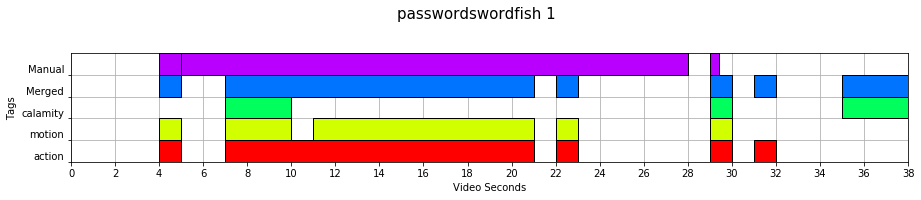

acertos:
	 (4, 1) tem interseção com (4, 1)
	 (5, 23) tem interseção com (4, 1)
	 (29, 0.3999999999999986) tem interseção com (29, 1)
3 acertos para um total de 3 efeitos
acerto de 100%
Video : pirates 600 128kbmp3 1


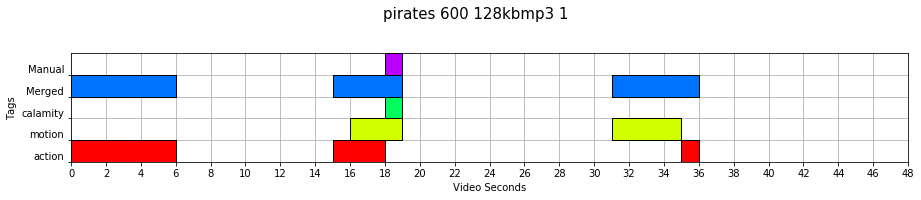

acertos:
	 (18, 1) tem interseção com (15, 4)
1 acertos para um total de 1 efeitos
acerto de 100%
Video : prince of persia the sands of time movie trailer


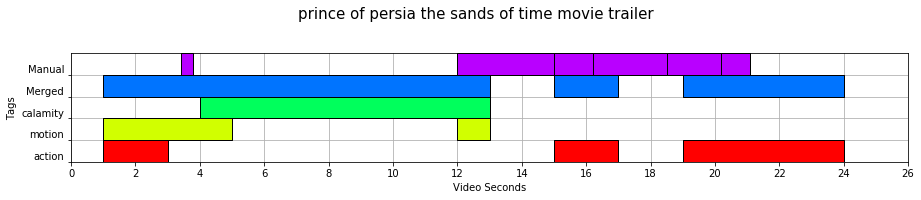

acertos:
	 (3.4, 0.3999999999999999) tem interseção com (1, 12)
	 (12, 3) tem interseção com (1, 12)
	 (15, 1.1999999999999993) tem interseção com (15, 2)
	 (16.2, 2.3000000000000007) tem interseção com (15, 2)
	 (18.5, 1.6999999999999993) tem interseção com (19, 5)
	 (20.2, 0.9000000000000021) tem interseção com (19, 5)
6 acertos para um total de 6 efeitos
acerto de 100%
Video : rambo-tlr2 h720p


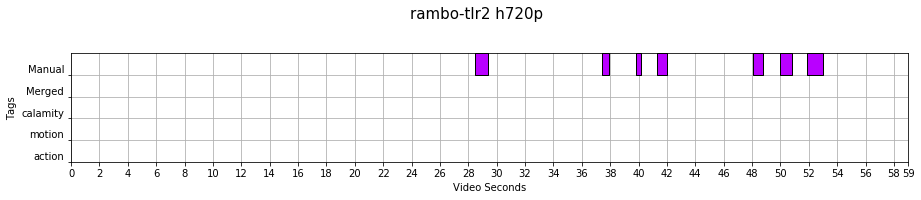

acertos:
0 acertos para um total de 7 efeitos
acerto de 0%
Video : transporter


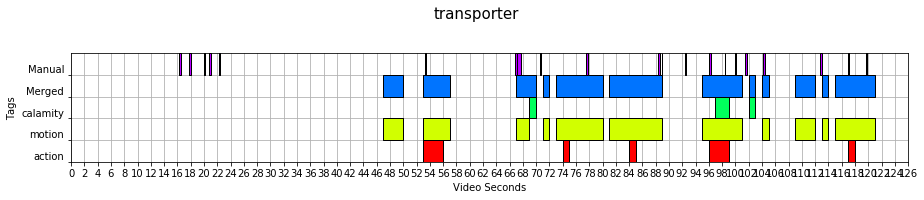

acertos:
	 (53.3, 0.20000000000000284) tem interseção com (53, 4)
	 (66.9, 0.1999888888888819) tem interseção com (67, 3)
	 (67.09998888888889, 0.7000111111111096) tem interseção com (67, 3)
	 (77.5, 0.29999999999999716) tem interseção com (73, 7)
	 (88.4, 0.29999999999999716) tem interseção com (81, 8)
	 (88.9, 0.09999999999999432) tem interseção com (81, 8)
	 (96.1, 0.20000000000000284) tem interseção com (95, 6)
	 (98.4, 0.09999999999999432) tem interseção com (95, 6)
	 (99.9, 0.19999999999998863) tem interseção com (95, 6)
	 (104.1, 0.30000000000001137) tem interseção com (104, 1)
	 (112.7, 0.29999999999999716) tem interseção com (113, 1)
	 (116.9, 0.19999999999998863) tem interseção com (115, 6)
	 (119.6, 0.20000000000000284) tem interseção com (115, 6)
13 acertos para um total de 21 efeitos
acerto de 61%
Video : tron legacy official comic con teaser trailer hd


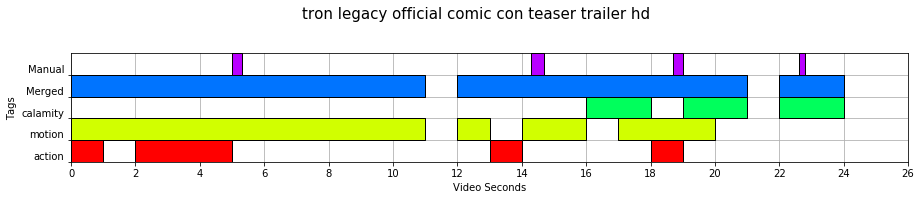

acertos:
	 (5, 0.2999999999999998) tem interseção com (0, 11)
	 (14.3, 0.3999999999999986) tem interseção com (12, 9)
	 (18.7, 0.3000000000000007) tem interseção com (12, 9)
	 (22.6, 0.1999999999999993) tem interseção com (22, 2)
4 acertos para um total de 4 efeitos
acerto de 100%


In [186]:
path = 'data/recognition/'

acertos_por_arquivo = {}

for filename in os.listdir(path):
 
    #filename = 'Pirates 600 128Kbmp3 1.json'
    with open(path+filename) as json_file:
        json_data = json.load(json_file)
    
    filename = os.path.splitext(filename)[0]  # removendo extensão
    print("Video : %s" % filename)
        
    with open('data/markupSEM.json') as json_file:
        markupSEM = json.load(json_file)

    allConcepts = createAllConcepts(json_data)

    conceptDict = createConceptDict(allConcepts,json_data)
    
    detectedConcepts = ['action', 'motion', 'calamity']

    ## insert predictions
    predictions = {}
    for concept in detectedConcepts:
        predictions[concept] =(findOcorrences(conceptDict[concept]))

    ## add merged predictions
    #create merged prediction : or's the 1's in each list into a single list
    mergedPrediction = mergeConcepts(*filter(None, [conceptDict[x] for x in detectedConcepts]))
    # Explanation:
    # [conceptDict[x] for x in detectedConcepts]  returns lists that are in detectedConcepts (i.e the lists  selected to show)
    # filter removes the lists that could be empty (i.e. the concept was  not found)
    # * unpacks the list into the arguments (which are also lists, but whatever...)
    # mergeConcepts merges the 1's of all the lists into a single  

    ## add merged markup
    detectedConcepts.append('Merged')
    predictions['Merged'] = (findOcorrences(mergedPrediction)) 

    addOne = True ## ATENÇÃO, ADD 1s A MAIS APÓS CADA FIM DE EFEITO. VEJA EXPLICAÇÃO NA CÉLULA ABAIXO

    ## add manual markup (ground truth) 
    detectedConcepts.append('Manual')
    predictions['Manual'] = []
    for markup in markupSEM[filename]['VibrationType']:
        # converting time of end into duration of effects
        markup[1] = (markup[1] - markup[0])
        if addOne: markup[1] += 1
        predictions['Manual'].append(tuple(markup))
    
    
    plotConcepts(filename,detectedConcepts,predictions)
    
    print("acertos:")
    hits = 0
    for markup in predictions['Manual']:
        inicio = markup[0]
        duracao = markup[1]
        for prediction in predictions['Merged']:
            if ((prediction[0] >= inicio and prediction[0] <= inicio+duracao) or (prediction[0] <= inicio and prediction[0]+prediction[1] >= inicio )):
                print("\t",markup,"tem interseção com",prediction)
                hits += 1
                break
    print("%d acertos para um total de %d efeitos" %(hits, len(predictions['Manual'])))
    porcentagem_de_acertos = hits/len(predictions['Manual'])*100
    acertos_por_arquivo[filename] = porcentagem_de_acertos
    print("acerto de %d%%" %porcentagem_de_acertos)
    
    


Explicação: segundo [yuan](https://www.researchgate.net/publication/276466001_Perceived_Synchronization_of_Mulsemedia_Services) temos [0,+1s] de tempo para sincronizar. Portanto vamos adicionar 1s a mais em cada efeito de vibração, gerando um 'intervalo de confiança' em que ainda dá para passar o efeito.  Isso vai servir para facilitar a comparação com o efeito 'Merged' gerado pela rede com a anotação manual

In [169]:
acertos_por_arquivo

{'2012 official trailer 4 hd': 62.5,
 'a chinese ghost story1 xvid': 45.45454545454545,
 'afterlife': 50.0,
 'alien 600 128kbmp3': 60.0,
 'alien-resurrection-teaser-640': 100.0,
 'babylon ad trailer hd': 66.66666666666666,
 'babylonad': 53.84615384615385,
 'babylonad 1': 66.66666666666666,
 'babylonad 1 b': 66.66666666666666,
 'babylonad 1 c': 55.55555555555556,
 'babylonad 1 d': 66.66666666666666,
 'babylonad 2': 100.0,
 'babylonad 3': 0.0,
 'babylonad short': 66.66666666666666,
 'babylonad shortogg': 66.66666666666666,
 'babylonad trlr 01 1080p dl': 61.53846153846154,
 'centurio': 25.0,
 'csi': 33.33333333333333,
 'fastandfurious': 46.15384615384615,
 'fastandfurious 1': 0.0,
 'fastandfurious 2': 75.0,
 'fastandfurious 3': 100.0,
 'fringe': 0.0,
 'indiana jones 4-tlr2 h720p': 57.14285714285714,
 'indy4 1': 100.0,
 'indy4 2': 100.0,
 'indy4 3': 50.0,
 'iron man 2 trailer official': 100.0,
 'kick ass debut movie teaser trailer hd': 0.0,
 'passwordswordfish 1': 100.0,
 'pirates 600 128k

a média é : 61.34152355580928


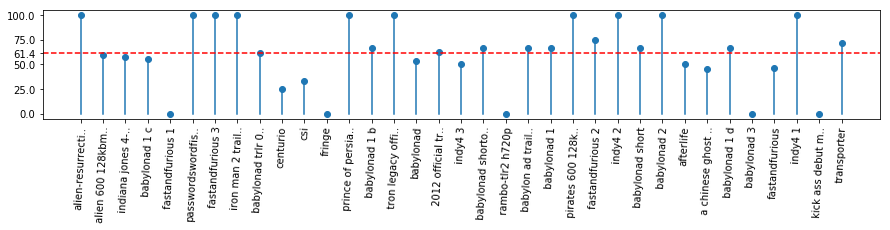

In [176]:
# Create data

fig, gnt = plt.subplots(figsize=(15, 2)) 
    
keys = list(acertos_por_arquivo.keys())

## Truncate list values up to max_char characters
max_char = 16
for i in range(len(keys)):
    keys[i] = keys[i][:max_char] + (keys[i][max_char:] and '..')


values = list(acertos_por_arquivo.values())

height = values
bars = keys 

my_range = list(range(0, len(keys), 1))

# Make the plot
plt.stem(values,basefmt=" ") # Alternative -> plt.bar(y_pos, height)

plt.yticks([0,25,50,61.4,75,100])
plt.xticks(y_pos, bars, rotation=87)


avg = sum(values)/len(values)
plt.axhline(y=avg, color='r', linestyle='--')

print("a média é :",avg)

 
# Show graphic
plt.savefig('porcentagem_de_acertos.pdf',bbox_inches='tight')
plt.show()